In [1]:
! pip install -q pyspark==3.4.1 spark-nlp==5.1.2
! pip install -q findspark

In [2]:
import time
import matplotlib.pyplot as plt
from collections import defaultdict

import findspark
findspark.init()
from pyspark.sql import SparkSession, Window
from pyspark import SparkContext, SparkConf

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import PipelineModel
from pyspark.sql import functions as func
from pyspark.ml import Pipeline
from collections import defaultdict
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as func


spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 5.1.2
Apache Spark version: 3.4.1


In [3]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xWfOl7SXQVwt0jZGAvIuQ16aEOgA5UOF' -O 'JaneAustine.txt'

--2023-11-17 11:28:00--  https://docs.google.com/uc?export=download&id=1xWfOl7SXQVwt0jZGAvIuQ16aEOgA5UOF
Resolving docs.google.com (docs.google.com)... 209.85.145.100, 209.85.145.113, 209.85.145.102, ...
Connecting to docs.google.com (docs.google.com)|209.85.145.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2h3ptt0m9a0cv69saov9fn6vp9fh6b9m/1700220450000/18299167658175267698/*/1xWfOl7SXQVwt0jZGAvIuQ16aEOgA5UOF?e=download&uuid=7d423b97-e79d-42ef-979b-9bc84dd17362 [following]
--2023-11-17 11:28:01--  https://doc-0o-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2h3ptt0m9a0cv69saov9fn6vp9fh6b9m/1700220450000/18299167658175267698/*/1xWfOl7SXQVwt0jZGAvIuQ16aEOgA5UOF?e=download&uuid=7d423b97-e79d-42ef-979b-9bc84dd17362
Resolving doc-0o-4c-docs.googleusercontent.com (doc-0o-4c-docs.googleusercontent.com)... 74.125.124.132, 2607:f8b0:

In [4]:
# spark_data = spark.read.text('/content/JaneAustine.txt').withColumn('sentence', func.split(func.col('value'), '\\.'))
sparkData = spark.read.text('/content/JaneAustine.txt')
sparkData = sparkData.filter(sparkData.value != '')
sparkData.show()

+--------------------+
|               value|
+--------------------+
|Project Gutenberg...|
|This eBook is for...|
|almost no restric...|
|re-use it under t...|
|with this eBook o...|
|Title: The Comple...|
| Author: Jane Austen|
|Editor: David Widger|
|Release Date: Jan...|
|   Language: English|
|Character set enc...|
|*** START OF THIS...|
|Produced by many ...|
|THE WORKS OF JANE...|
|Edited by David W...|
|Project Gutenberg...|
|             DEDI...|
|     This Jane Au...|
|         is dedic...|
|     Alice Goodso...|
+--------------------+
only showing top 20 rows



In [5]:
'''
preprocessing the text
1. punctuation removal
2. lower casing
3. Tokenization
4. Stop words removal
5. Stemming
6. Lemmatization
'''

# download lemmas_small.txt from drive
!wget --no-check-certificate 'https://drive.google.com/file/d/1FzfgBDMh1AcNNfwfy6VViMr1viwk2xS2/view?usp=sharing' -O 'lemmas_small.txt'


processDocumenter = DocumentAssembler()\
    .setInputCol("value")\
    .setOutputCol("document")


tokenizer = Tokenizer()\
    .setInputCols(['document'])\
    .setOutputCol('token')


stopWords = StopWordsCleaner()\
    .setInputCols(["token"])\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)


normalizer = Normalizer()\
    .setInputCols(['cleanTokens'])\
    .setOutputCol('normalized')\
    .setLowercase(True)\
    .setCleanupPatterns(["""[^\w\d\s]"""]) # punctuation removal


stemmer = Stemmer()\
    .setInputCols(["normalized"])\
    .setOutputCol("stem")


lemmatizer = Lemmatizer()\
    .setInputCols(["stem"])\
    .setOutputCol("lemma")\
    .setDictionary("/content/lemmas_small.txt", "->", "\t")


pipeline = Pipeline()\
    .setStages([
      processDocumenter,
      tokenizer,
      stopWords,
      normalizer,
      stemmer,
      lemmatizer
    ])


sparkDataClean = pipeline.fit(sparkData).transform(sparkData)


--2023-11-17 11:28:12--  https://drive.google.com/file/d/1FzfgBDMh1AcNNfwfy6VViMr1viwk2xS2/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 209.85.146.102, 209.85.146.101, 209.85.146.139, ...
Connecting to drive.google.com (drive.google.com)|209.85.146.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘lemmas_small.txt’

lemmas_small.txt        [ <=>                ]  82.63K  --.-KB/s    in 0.005s  

2023-11-17 11:28:13 (15.0 MB/s) - ‘lemmas_small.txt’ saved [84610]



In [6]:
sparkDataClean.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               value|            document|               token|         cleanTokens|          normalized|                stem|               lemma|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Project Gutenberg...|[{document, 0, 68...|[{token, 0, 6, Pr...|[{token, 0, 6, Pr...|[{token, 0, 6, pr...|[{token, 0, 6, pr...|[{token, 0, 6, pr...|
|This eBook is for...|[{document, 0, 63...|[{token, 0, 3, Th...|[{token, 5, 9, eB...|[{token, 5, 9, eb...|[{token, 5, 9, eb...|[{token, 5, 9, eb...|
|almost no restric...|[{document, 0, 67...|[{token, 0, 5, al...|[{token, 0, 5, al...|[{token, 0, 5, al...|[{token, 0, 5, al...|[{token, 0, 5, al...|
|re-use it under t...|[{document, 0, 66...|[{token, 0, 5, re...|[{token, 0, 5, re...|[{token, 0, 4, re...|

In [7]:
sparkDataClean.selectExpr("token.result").show(truncate=False)

+------------------------------------------------------------------------------------+
|result                                                                              |
+------------------------------------------------------------------------------------+
|[Project, Gutenberg's, The, Complete, Works, of, Jane, Austen, ,, by, Jane, Austen] |
|[This, eBook, is, for, the, use, of, anyone, anywhere, at, no, cost, and, with]     |
|[almost, no, restrictions, whatsoever, ., You, may, copy, it, ,, give, it, away, or]|
|[re-use, it, under, the, terms, of, the, Project, Gutenberg, License, included]     |
|[with, this, eBook, or, online, at, www.gutenberg.org]                              |
|[Title, :, The, Complete, Project, Gutenberg, Works, of, Jane, Austen]              |
|[Author, :, Jane, Austen]                                                           |
|[Editor, :, David, Widger]                                                          |
|[Release, Date, :, January, 25, ,, 2010, [

In [8]:
lemma = sparkDataClean.selectExpr('lemma.result')
lemma.show(truncate=False)

+---------------------------------------------------------------+
|result                                                         |
+---------------------------------------------------------------+
|[project, gutenberg, complet, work, jane, austen, jane, austen]|
|[ebook, us, anyon, anywher, cost]                              |
|[almost, restrict, whatsoev, mai, copi, give, awai]            |
|[reus, term, project, gutenberg, licens, includ]               |
|[ebook, onlin, wwwgutenbergorg]                                |
|[titl, complet, project, gutenberg, work, jane, austen]        |
|[author, jane, austen]                                         |
|[editor, david, widger]                                        |
|[releas, date, januari, 25, 2010, ebook, 31100]                |
|[languag, english]                                             |
|[charact, set, encod, ascii]                                   |
|[start, project, gutenberg, ebook, work, jane, austen]         |
|[produc, 

In [9]:
# a) Words in text along with their frequency

words = lemma.select(func.explode(lemma.result).alias('word'))
wordCount = words.groupBy('word').count()
wordCount.show(truncate=False)

+---------------+-----+
|word           |count|
+---------------+-----+
|still          |571  |
|hope           |968  |
|blossom        |3    |
|travel         |79   |
|entitl         |24   |
|art            |35   |
|imagin         |323  |
|eloqu          |17   |
|novelti        |26   |
|spoil          |16   |
|voic           |234  |
|inur           |5    |
|wretchedli     |8    |
|barrier        |3    |
|gallantri      |37   |
|goodwil        |42   |
|procur         |56   |
|reconcili      |17   |
|yestermorn     |1    |
|extraordinarili|1    |
+---------------+-----+
only showing top 20 rows



In [10]:
# -------------Print the total number of repeated and unique words used in JaneAustine.txt-------------

countWords = func.udf(lambda words: len(words), IntegerType())

totalWords = lemma.select('result')\
                  .withColumn('count', countWords(func.col('result')))

totalCount = totalWords.agg(func.sum('count')).collect()[0][0]

distinctWords = totalWords.select(func.explode(totalWords.result).alias('words'))
distinctCount = distinctWords.distinct().count()

In [11]:
# b) Total number of words in the text
print(f'The total number of words used in JaneAustine.txt file equals: {totalCount}')
totalWords.show(truncate=False)

The total number of words used in JaneAustine.txt file equals: 348880
+---------------------------------------------------------------+-----+
|result                                                         |count|
+---------------------------------------------------------------+-----+
|[project, gutenberg, complet, work, jane, austen, jane, austen]|8    |
|[ebook, us, anyon, anywher, cost]                              |5    |
|[almost, restrict, whatsoev, mai, copi, give, awai]            |7    |
|[reus, term, project, gutenberg, licens, includ]               |6    |
|[ebook, onlin, wwwgutenbergorg]                                |3    |
|[titl, complet, project, gutenberg, work, jane, austen]        |7    |
|[author, jane, austen]                                         |3    |
|[editor, david, widger]                                        |3    |
|[releas, date, januari, 25, 2010, ebook, 31100]                |7    |
|[languag, english]                                             |2

In [12]:
# c) Total number of unique words in the text
print(f'The total number of words used in JaneAustine.txt file equals: {distinctCount}')
distinctWords.show(truncate=False)

The total number of words used in JaneAustine.txt file equals: 14500
+---------+
|words    |
+---------+
|project  |
|gutenberg|
|complet  |
|work     |
|jane     |
|austen   |
|jane     |
|austen   |
|ebook    |
|us       |
|anyon    |
|anywher  |
|cost     |
|almost   |
|restrict |
|whatsoev |
|mai      |
|copi     |
|give     |
|awai     |
+---------+
only showing top 20 rows



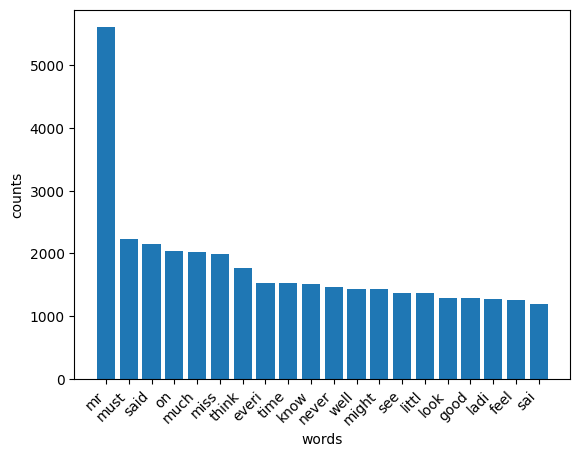

In [13]:
# -------------Filtering out the top 20 most repeated words in JaneAustine.txt-------------
ascendingOrder = wordCount.orderBy(func.asc('count'))
top_20_words = wordCount.orderBy(func.desc('count')).limit(20)

# First we collect the data to the driver node
localData = top_20_words.collect()

words_ = [row['word'] for row in localData]
counts_ = [row['count'] for row in localData]

plt.bar(words_, counts_)
plt.xticks(rotation=45, ha='right')
plt.xlabel('words')
plt.ylabel('counts')
plt.show();

In [14]:
modelDocumenter = DocumentAssembler()\
    .setInputCol("value")\
    .setOutputCol("document")

sentencerDL = SentenceDetectorDLModel\
    .pretrained("sentence_detector_dl", "en")\
    .setInputCols(['document'])\
    .setOutputCol("sentences")

sdPipeline = PipelineModel(stages=[modelDocumenter, sentencerDL])
sdModel = LightPipeline(sdPipeline)

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


In [15]:
rSpark = SparkSession.builder\
                    .appName('sentenceExtractor')\
                    .master("local[*]")\
                    .getOrCreate()

rSpark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
# rSpark
sc = SparkContext.getOrCreate(rSpark.conf)

In [16]:
sc

<SparkContext master=local[*] appName=Spark NLP>

In [17]:
data = sc.textFile('/content/JaneAustine.txt')
data.collect()

['',
 "Project Gutenberg's The Complete Works of Jane Austen, by Jane Austen",
 '',
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or',
 're-use it under the terms of the Project Gutenberg License included',
 'with this eBook or online at www.gutenberg.org',
 '',
 '',
 'Title: The Complete Project Gutenberg Works of Jane Austen',
 '',
 'Author: Jane Austen',
 '',
 'Editor: David Widger',
 '',
 'Release Date: January 25, 2010 [EBook #31100]',
 '',
 'Language: English',
 '',
 'Character set encoding: ASCII',
 '',
 '*** START OF THIS PROJECT GUTENBERG EBOOK THE WORKS OF JANE AUSTEN ***',
 '',
 '',
 '',
 '',
 'Produced by many Project Gutenberg volunteers.',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'THE WORKS OF JANE AUSTEN',
 '',
 '',
 '',
 'Edited by David Widger',
 '',
 'Project Gutenberg Editions',
 '',
 '',
 '',
 '             DEDICATION',
 '',
 '     This Jane Austen collection',
 '         is dedica

In [18]:
nonEmptyLines = data.filter(lambda x: len(x) > 0)
nonEmptyLines.collect()

["Project Gutenberg's The Complete Works of Jane Austen, by Jane Austen",
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or',
 're-use it under the terms of the Project Gutenberg License included',
 'with this eBook or online at www.gutenberg.org',
 'Title: The Complete Project Gutenberg Works of Jane Austen',
 'Author: Jane Austen',
 'Editor: David Widger',
 'Release Date: January 25, 2010 [EBook #31100]',
 'Language: English',
 'Character set encoding: ASCII',
 '*** START OF THIS PROJECT GUTENBERG EBOOK THE WORKS OF JANE AUSTEN ***',
 'Produced by many Project Gutenberg volunteers.',
 'THE WORKS OF JANE AUSTEN',
 'Edited by David Widger',
 'Project Gutenberg Editions',
 '             DEDICATION',
 '     This Jane Austen collection',
 '         is dedicated to',
 '     Alice Goodson [Hart] Woodby',
 '[Note: The accompanying HTML file has active links to all the volumes',
 'and chapters in this se

In [19]:
def find_sentence(data, length):
    sentence_counts = defaultdict(int)
    for row in data.collect():
        sentences = row.split('.')
        for sentence in sentences:
            words = sentence.split()
            if len(words) == length:
                sentence_counts[sentence] += 1
    return sentence_counts


fiveWordSentences = find_sentence(nonEmptyLines, 5)
tenWordSentences = find_sentence(nonEmptyLines, 10)

In [20]:
# E) Counting the 5-word and 10-word sentences
print(len(fiveWordSentences))
fiveWordSentences

5190


defaultdict(int,
            {'THE WORKS OF JANE AUSTEN': 1,
             'and chapters in this set': 1,
             'daughter of James Stevenson, Esq': 1,
             ', great grandson of the': 1,
             'thing deserved by his own': 1,
             '--Three girls, the two eldest': 1,
             'been anxiously giving her daughters': 1,
             '  All equality of alliance must': 1,
             "  Thirteen winters' revolving frosts had": 1,
             'Sir Walter has resented it': 1,
             '  The disgrace of his first': 1,
             'had been constantly exceeding it': 1,
             'disgrace his name so far': 1,
             '  If he will adopt these': 1,
             '  She wanted it to be': 1,
             "  She rated Lady Russell's influence": 1,
             'without a change of abode': 1,
             '  It was a much safer': 1,
             "  And with regard to Anne's": 1,
             "Walter's have found too much": 1,
             'our rich naval 

In [21]:
print(len(tenWordSentences))
tenWordSentences

6443


defaultdict(int,
            {'contemplating the limited remnant of the earliest patents; there any': 1,
             'was the page at which the favourite volume always opened:': 1,
             "Precisely such had the paragraph originally stood from the printer's": 1,
             'how mentioned in Dugdale, serving the office of high sheriff,': 1,
             'motto:--"Principal seat, Kellynch Hall, in the county of Somerset," and': 1,
             '  He considered the blessing of beauty as inferior only to': 1,
             'sensible, deserving woman, who had been brought, by strong attachment': 1,
             "prided himself on remaining single for his dear daughters' sake": 1,
             'which he had not been very much tempted to do': 1,
             'country family of respectability and large fortune, and had therefore': 1,
             "Lady Russell's temples had long been a distress to him": 1,
             'Elizabeth did not quite equal her father in personal contentment':

In [22]:
rSpark.stop()

In [23]:
spark.stop()